## Face Detection Model Using CNNs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, Activation
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define the new directory path
new_directory = '/content/drive/MyDrive/Colab Notebooks'

# Change the current working directory to the new one
os.chdir(new_directory)

# Verify the change by printing the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks


### Data Preprocessing

In [4]:
# Set the directory where the data is stored
data_dir = "Data/lfw_funneled/lfw_funneled"

# Define the labels
labels= os.listdir(data_dir)

In [5]:
def rand_label_Func(labels, data_dir):
    rand_label= np.random.choice(a=labels)
    path = os.path.join(data_dir, rand_label)

    if len(os.listdir(path)) == 1:
        img= os.listdir(path)[0]
        rand_img= os.path.join(path, img)
    else:
        img= np.random.choice(a= os.listdir(path))
        rand_img= os.path.join(path, img)
    return str(rand_img)

In [6]:
Images_list = []
Target_list = []

for label in labels[:600]:
    path = os.path.join(data_dir, label)
    img_set= set(os.listdir(path))

    for img in os.listdir(path):
        rand_label= rand_label_Func(labels, data_dir)
        label_list= [os.path.join(path, img), rand_label]
        Images_list.append(label_list)
        Target_list.append(0)

        img_set.remove(img)
        for next_img in img_set:
            label_list= [os.path.join(path, img), os.path.join(path, next_img)]
            Images_list.append(label_list)
            Target_list.append(1)

            rand_label= rand_label_Func(labels, data_dir)
            label_list= [os.path.join(path, img), rand_label]
            Images_list.append(label_list)
            Target_list.append(0)

Images_list= np.array(Images_list)
Target_list= np.array(Target_list)
print('Dataset Shape: ', Images_list.shape)
print('The ration of classes: ', sum(Target_list)/len(Target_list))

Dataset Shape:  (5837, 2)
The ration of classes:  0.4046599280452287


In [7]:
# Defining parameters
img_width, img_height = 128, 128
batch_size = 32
No_epochs= 100

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Images_list, Target_list, test_size=0.1, random_state=42, stratify=Target_list)

# Split the data into training and dev sets
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print('Training set size: ', len(X_train))
print('Test set size: ', len(X_test))
print('Dev set size: ', len(X_dev))

Training set size:  4727
Test set size:  584
Dev set size:  526


### Sample images

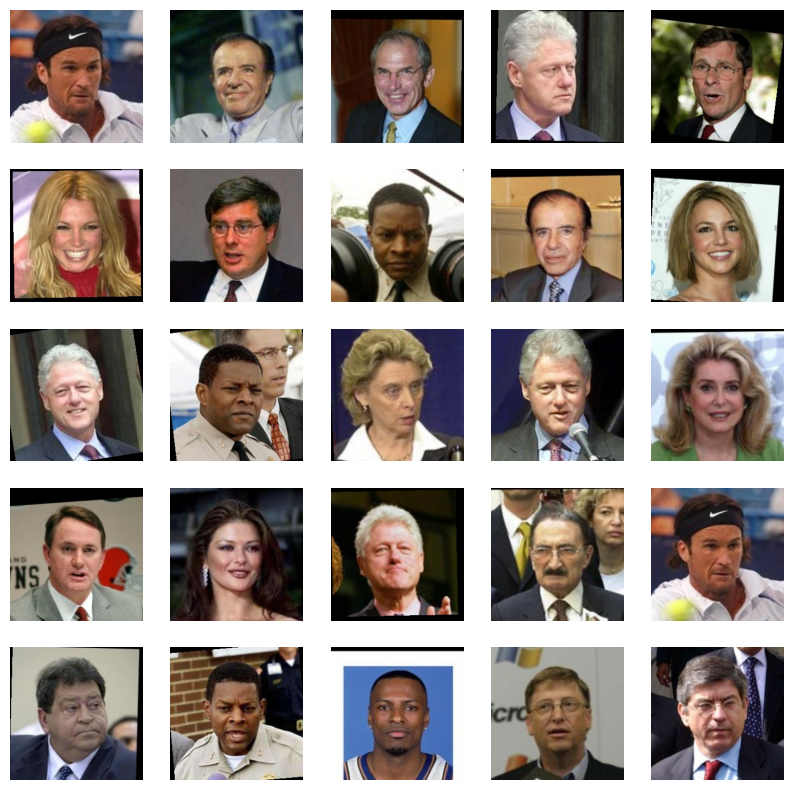

In [9]:
# Plot the images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = Image.open(np.random.choice(X_train[:,0]))
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [10]:
# Loading and preprocessing images
def load_images(X, img_width, img_height):
    images = []
    for image_path in X:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height)) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = image / 255.0  # Normalize pixel values
        images.append(image)

    images = np.array(images)
    return images

# Load and preprocess images
X_train= np.array([load_images(pair, img_width, img_height) for pair in X_train])

X_test = np.array([load_images(pair, img_width, img_height) for pair in X_test])

X_dev = np.array([load_images(pair, img_width, img_height) for pair in X_dev])

In [11]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
    # Set device for TensorFlow operations
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
else:
    print('GPU is not available')

GPU is available


### Defining the model

In [12]:
# Base convolutional model
image_input1 = Input(shape= (img_width, img_height, 3))
image_input2 = Input(shape= (img_width, img_height, 3))

In [13]:
# First convolutional block
Conv1 = Conv2D(16, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))
Batch1 = BatchNormalization()
Act1 = Activation('relu')
Pool1 = MaxPooling2D((2, 2))

# Second convolutional block
Conv2 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))
Batch2 = BatchNormalization()
Act2 = Activation('relu')

Conv3 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))
Batch3 = BatchNormalization()
Act3 = Activation('relu')

# skip connection
Add1 = Add()
Pool2 = MaxPooling2D((2, 2))

# Third convolutional block
Conv4 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))
Batch4 = BatchNormalization()
Act4 = Activation('relu')

Conv5 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))
Batch5 = BatchNormalization()
Act5 = Activation('relu')

# skip connection
Add2 = Add()
Pool3 = MaxPooling2D((2, 2))

# Fourth convolutional block
Conv6 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))
Batch6 = BatchNormalization()
Act6 = Activation('relu')
Pool4 = MaxPooling2D((2, 2))

# Flatten and dense layers
Flatten1 = Flatten()

In [14]:
def Generator_model(image_input):
    # First convolutional block
    x1= Conv1(image_input)
    x1= Batch1(x1)
    x1= Act1(x1)
    x1= Pool1(x1)

    # Second convolutional block
    x2= Conv2(x1)
    x2= Batch2(x2)
    x2= Act2(x2)

    x3= Conv3(x2)
    x3= Batch3(x3)
    x3= Act3(x3)

    # skip connection
    x3= Add1([x2, x3])
    x3= Pool2(x3)

    # Third convolutional block
    x4= Conv4(x3)
    x4= Batch4(x4)
    x4= Act4(x4)

    x5= Conv5(x4)
    x5= Batch5(x5)
    x5= Act5(x5)

    # skip connection
    x5= Add2([x4, x5])
    x5= Pool3(x5)

    # Fourth convolutional block
    x6= Conv6(x5)
    x6= Batch6(x6)
    x6= Act6(x6)
    x6= Pool4(x6)

    # Flatten and dense layers
    x7= Flatten1(x6)

    return x7

In [15]:
x1= Generator_model(image_input1)
x2= Generator_model(image_input2)

In [16]:
# Merge branches
Dense1 = Dense(128, activation='relu')
Dropout1 = Dropout(0.2)
Dense2 = Dense(1, activation='sigmoid')

In [17]:
# Defining the discriminator model
def discriminator_model(x1, x2):
    X1= Dense1(x1 - x2)
    X2= Dropout1(X1)
    X3= Dense2(X2)
    return X3

In [18]:
output= discriminator_model(x1, x2)

In [19]:
# Create model
model = Model(inputs=[image_input1, image_input2], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]',          

In [20]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [21]:
# Train model
with tf.device('/GPU:0'):
  history = model.fit([X_train[:,0], X_train[:,1]], y_train, epochs= No_epochs, batch_size= batch_size, validation_data=([X_dev[:,0], X_dev[:,1]], y_dev))

Epoch 1/100
148/148 [==============================] - 22s 63ms/step - loss: 1.4903 - accuracy: 0.6279 - val_loss: 1.1181 - val_accuracy: 0.6578
Epoch 2/100
148/148 [==============================] - 7s 44ms/step - loss: 0.9593 - accuracy: 0.7739 - val_loss: 0.9374 - val_accuracy: 0.7719
Epoch 3/100
148/148 [==============================] - 7s 45ms/step - loss: 0.7635 - accuracy: 0.8655 - val_loss: 0.8892 - val_accuracy: 0.7814
Epoch 4/100
148/148 [==============================] - 6s 43ms/step - loss: 0.6735 - accuracy: 0.8936 - val_loss: 0.8381 - val_accuracy: 0.8213
Epoch 5/100
148/148 [==============================] - 7s 45ms/step - loss: 0.5666 - accuracy: 0.9196 - val_loss: 0.7211 - val_accuracy: 0.8536
Epoch 6/100
148/148 [==============================] - 6s 44ms/step - loss: 0.5178 - accuracy: 0.9334 - val_loss: 0.7436 - val_accuracy: 0.8422
Epoch 7/100
148/148 [==============================] - 7s 44ms/step - loss: 0.4850 - accuracy: 0.9359 - val_loss: 0.7055 - val_accuracy

### Evaluating and testing the model

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test[:,0], X_test[:,1]], y_test, batch_size=batch_size)
print(f"Test accuracy: {accuracy}")

19/19 [==============================] - 1s 44ms/step - loss: 0.3793 - accuracy: 0.9298
Test accuracy: 0.9297945499420166


In [23]:
# Make predictions
y_pred = model.predict([X_test[:,0], X_test[:,1]], batch_size=batch_size)
y_pred = [1 if pred>0.5 else 0  for pred in y_pred]

19/19 [==============================] - 1s 13ms/step


In [24]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 score: {f1}")

F1 score: 0.9297945205479452


In [25]:
# The classification report
Report = classification_report(y_test, y_pred)
print(Report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       348
           1       0.92      0.91      0.91       236

    accuracy                           0.93       584
   macro avg       0.93      0.93      0.93       584
weighted avg       0.93      0.93      0.93       584



### Confusion Matrix for test set

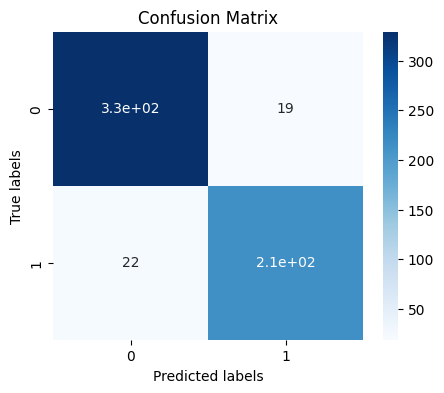

In [26]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Loss and accuracy in training and validating the model

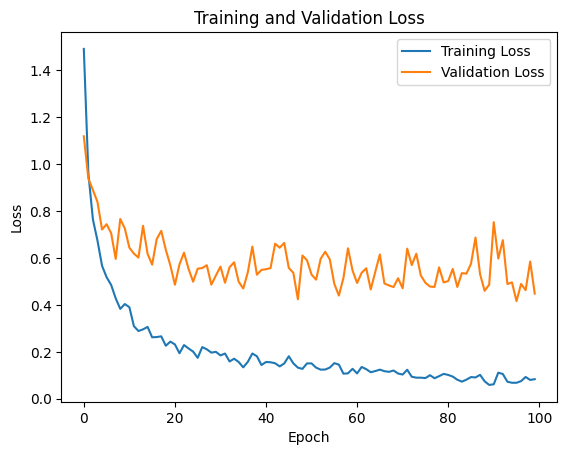

In [27]:
# Plot the loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

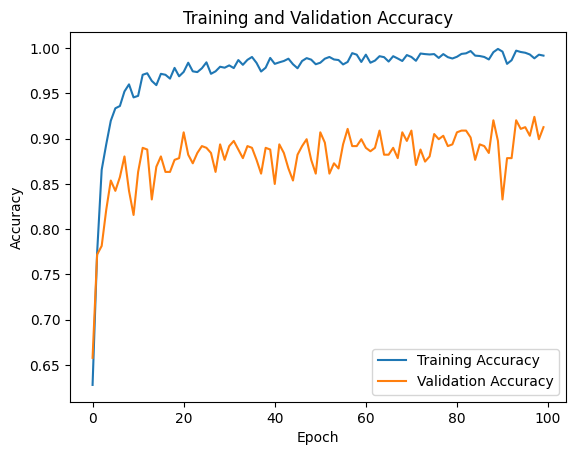

In [28]:
# Plot the accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Saving the model

In [29]:
# Define the directory and filename
save_dir = 'Saved Models'
model_name = 'Face-Detection-Training-CNN-Model-5.h5'

# Save the model
model.save(os.path.join(save_dir, model_name))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
